<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [6]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [7]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'

In [8]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [9]:

nn = 4

In [10]:

arrays = [np.asarray([[],[]]) for jj in range(12)]

print(nn)
array_ = np.load(os.path.join(root_data,'SDSS_BOSS_preprocessed/%s_%d.npy'%(label,nn)), allow_pickle=True)
for jj in range(12):
    arr = np.vstack(array_[jj])
    arrays[jj] = np.append(arrays[jj],arr)

4


In [11]:
res_fluxes,res_inv_vars,res_masks,redshifts,SNs, ras, decs, category,sublabel, MJD, plate_id, fiber = arrays

In [12]:
res_fluxes.shape

(761053000,)

In [13]:
import time

In [14]:
a= time.time()
res_flux = np.expand_dims(res_fluxes[0],0)
for ii in range(1,1000):
    res_flux = np.vstack((res_flux,res_fluxes[ii]))
print(time.time()-a)

0.021901845932006836


In [15]:
len(res_fluxes)/1000*2/60

25368.433333333334

In [16]:
res_fluxes_ = np.reshape(res_fluxes,[-1,1000])
res_inv_vars_ =  np.reshape(res_inv_vars,[-1,1000])
res_masks_ =  np.reshape(res_masks,[-1,1000])
#redshifts =  np.reshape(redshifts,[-1,1000])
# SNs =  np.reshape(SNs,[-1,1000])
# ras =  np.reshape(ras,[-1,1000])
# decs =  np.reshape(decs,[-1,1000])
# category=  np.reshape(category,[-1,1000])
# sublabel =  np.reshape(sublabel,[-1,1000])
# MJD =  np.reshape(MJD,[-1,1000])
# plate_id =  np.reshape(plate_id,[-1,1000])
# fiber =  np.reshape(fiber,[-1,1000])

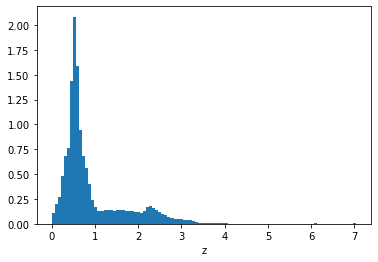

In [17]:
_ = plt.hist(redshifts,bins=100,density=True)
plt.xlabel('z')
plt.show()

In [18]:
# res_fluxes_   = np.asarray(res_fluxes)
# res_inv_vars_ = np.asarray(res_inv_vars)
# res_masks_    = np.asarray(res_masks)

In [19]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    indx = np.where((redshifts>min_z)*(redshifts<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel = redshift_bin(min_z, max_z, redshifts, [res_fluxes_, res_masks_, res_inv_vars_, redshifts, ras, decs, category, sublabel])

new datasize:  94857


In [20]:
DATASET_SIZE = len(res_fluxes)

In [21]:
SNs =[]
for ii in range(DATASET_SIZE):
    SNs.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])//np.sqrt(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])])))
SNs= np.asarray(SNs)

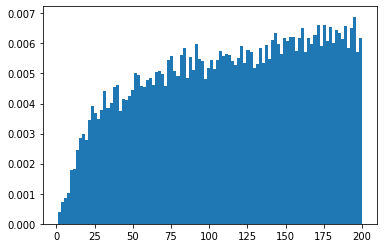

In [22]:
_ = plt.hist(SNs, density=True,bins=100,range=(1,200))

Text(0.5, 0, 'S/N')

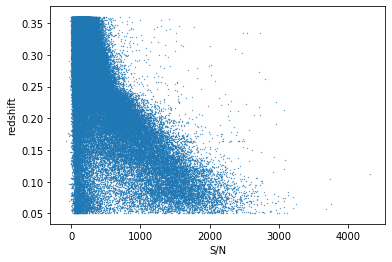

In [23]:
plt.scatter(SNs,redshifts, s=0.1)
plt.ylabel('redshift')
plt.xlabel('S/N')

In [24]:
SNs.shape, redshifts.shape

((94857,), (94857,))

In [25]:
def SN_bin(min_SN, SNs, arrays):
    num  = len(arrays)
    indx = np.where(SNs>min_SN)[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = SN_bin(min_SN, SNs, [res_fluxes, res_masks, res_inv_vars, redshifts,SNs,ras, decs, category, sublabel])

new datasize:  89606


In [26]:
boolean_mask = (res_masks==0)

In [27]:
mask_fracs = np.mean(boolean_mask,axis=1)

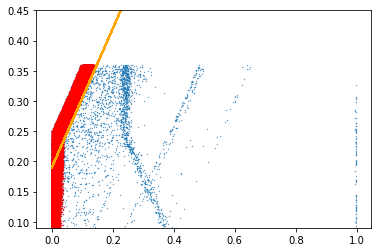

In [28]:
plt.scatter(mask_fracs, redshifts, s=0.1)
plt.plot(mask_fracs,mask_fracs*1.15+0.19, color='orange')
keep = redshifts>mask_fracs*1.15+0.19
keep_low = mask_fracs<0.04
keep = np.logical_or(keep,keep_low)
plt.scatter(mask_fracs[keep], redshifts[keep], color='red', s=0.1)
plt.ylim(0.09,0.45)
plt.show()

In [29]:
def mask_bin(keep, arrays):
    num  = len(arrays)
    arrays_new = [arrays[ii][keep] for ii in range(num)]
    print('new datasize: ', len(arrays_new[0]))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = mask_bin(keep, [res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel])

new datasize:  87211


In [30]:
boolean_mask = (res_masks==0)

In [31]:
mask_fracs = np.mean(boolean_mask,axis=1)
max(mask_fracs)

0.146

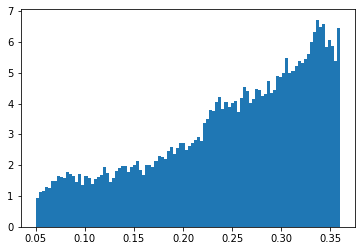

In [32]:
_ = plt.hist(redshifts, density=True, bins=100)

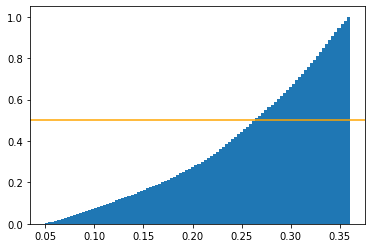

In [33]:
_ = plt.hist(redshifts, density=True, bins=100, cumulative=True)
plt.axhline(0.5,color='orange')

In [34]:
# def calc_noise_floor(res_fluxes, res_masks, res_inv_vars):
#     floors = []
#     sanity = []
#     MAXs   = []
#     for ii in range(len(res_fluxes)):
#         MAX = max(res_fluxes[ii][res_masks[ii]]*np.sqrt(res_inv_vars[ii][res_masks[ii]]))
#         MAXs.append(MAX)
#         N   = np.where(res_fluxes[ii][res_masks[ii]]*np.sqrt(res_inv_vars[ii][res_masks[ii]])==MAX)[0]
#         if MAX>50.:
#             print(N)
#             floor2 = (res_fluxes[ii][res_masks[ii]][N]/50.)**2-1./res_inv_vars[ii][res_masks[ii]][N]
#             sanity.append(res_fluxes[ii][res_masks[ii]][N]/np.sqrt(floor2+1./res_inv_vars[ii][res_masks[ii]][N]))
#             floors.append(floor2)
#         else:
#             floors.append(0.)
#     return floors, sanity, MAXs


# noise_floors, sanity, MAXs = calc_noise_floor(res_fluxes, res_masks, res_inv_vars)

# sanity = np.asarray(sanity)
# noise_floors = np.asarray(noise_floors)
# MAXs = np.asarray(MAXs)

#_ = plt.hist(MAXs, bins=100)

In [35]:
np.save(os.path.join(root_prepped,'prepped_data_spectra_%s_batch%d.npy'%(label_,nn)), [res_fluxes, res_masks, res_inv_vars])

np.save(os.path.join(root_prepped,'prepped_data_prop_%s_batch%d.npy'%(label_,nn)), [redshifts, SNs, ras, decs, category, sublabel])

In [36]:
nn

4